# Correlated Noisy
---
This notebook generates Noisy [1,2] movies from correlated input noise.

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [1]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import xarray as xr
import scipy as sci
from matplotlib import animation
from  scipy.spatial import distance
import skimage.transform
from pynoisy import eht_functions as ehtf
import ehtim as eh

Welcome to eht-imaging! v 1.1.1 



In [2]:
"""
Function definitions
"""
def load_fits(path):
    image = eh.image.load_fits(path)
    image = image.regrid_image(image.fovx(), pynoisy.core.get_image_size()[0])
    return pynoisy.envelope.grid(data=image.imarr())

def rbf_kernel_covariance(x, y, sigma=1):
    """Exponentiated quadratic distance"""
    xa = np.stack((x.ravel(), y.ravel()), axis=1)
    norm = -0.5 * distance.cdist(xa, xa, 'sqeuclidean') / sigma**2
    return np.exp(norm)

def generate_correlated_noise(nt=50, nx=64, ny=64, sigma=0.05):
    grid = pynoisy.utils.get_grid(nx, ny)
    num_frames = nt
    x, y = np.meshgrid(grid.x, grid.y)
    cov = rbf_kernel_covariance(x, y, sigma)
    correlated_noise = np.random.multivariate_normal(
        mean=np.zeros((grid.dims['x'], grid.dims['y'])).ravel(), 
        cov=cov, size=num_frames).reshape(num_frames, grid.dims['x'], grid.dims['y'])
    return correlated_noise

def generate_rotating_envelope(path):
    envelope = load_fits(path)
    
    # Mask enevlope before rotation
    mask = np.ones(envelope.shape)
    mask[envelope.r > 0.5] = 0
    envelope *= mask
    
    angles = np.linspace(0, 360, pynoisy.core.get_num_frames())
    rotating_envelope = []
    for angle in angles:
        rotating_envelope.append(skimage.transform.rotate(envelope.data, angle))
    return np.array(rotating_envelope)

## Correlated Noisy

In [3]:
advection = pynoisy.advection.disk(64, 64)
diffusion = pynoisy.diffusion.ring(64, 64)
solver = pynoisy.forward.NoisySolver(64, 64, advection, diffusion)
source = generate_correlated_noise()
correlated_field = solver.run_symmetric(source=source, verbose=True)

100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


<IPython.core.display.Javascript object>


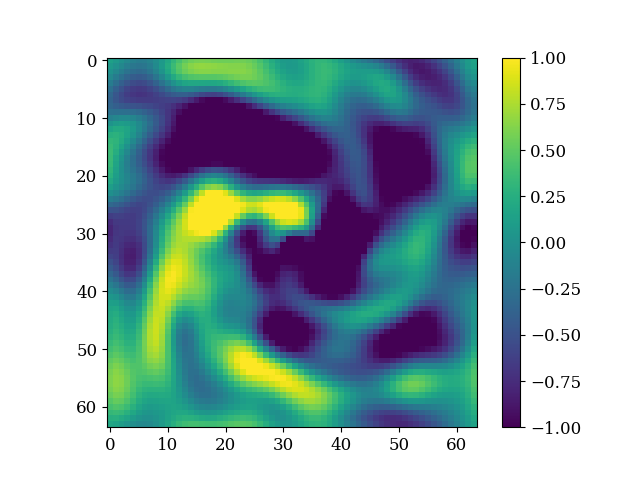

In [4]:
%matplotlib notebook
correlated_field.noisy_methods.get_animation(vmin=-1, vmax=1)

## Dynamic Envelope

In [ ]:
path = '/home/aviad/Code/eht-imaging/SgrA/synthetic_data_SGRA_3599_lo/dataset3.0/dbsrc_fiducial/dbsrc_fiducial.fits'
rotating_envelope = generate_rotating_envelope(path)
rotating_envelope = xr.DataArray(
    data=rotating_envelope,
    coords=correlated_field.coords
)

<IPython.core.display.Javascript object>


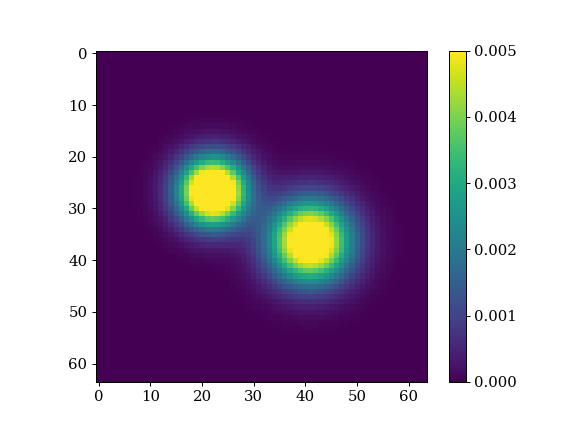

In [25]:
%matplotlib notebook
rotating_envelope.noisy_methods.get_animation(vmin=0, vmax=0.005)

<IPython.core.display.Javascript object>


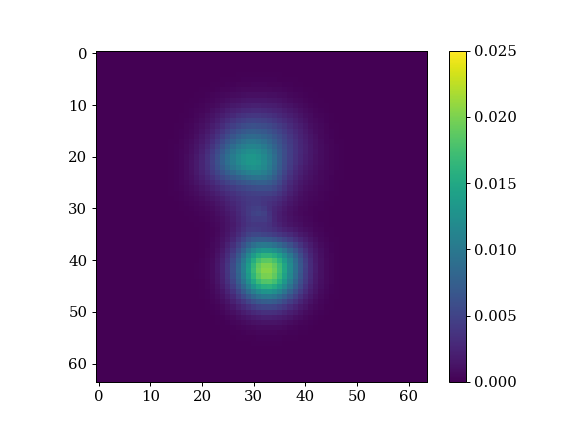

In [39]:
alpha = 0.7
dynamic_correlated_field = rotating_envelope * np.exp(-alpha * correlated_field)
dynamic_correlated_field.noisy_methods.get_animation(vmin=0, vmax=0.025)